<a href="https://colab.research.google.com/github/abs-git/GNN/blob/main/Graph_classification_with_Molecule_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric

# Load data

In [4]:
# MoleculeNet collection
# ESOL data

import rdkit
from torch_geometric.datasets import MoleculeNet

data = MoleculeNet(root = ".", name = "ESOL")

data

Processing...
Done!


ESOL(1128)

In [5]:
# edge_index = graph connections
# smiles = molcule with its atoms structure
# X = node features (32 nodes have each 9 features)
# y = labels (dimension)


print("type         : {}".format(type(data)))
print("features     : {}".format(data.num_features))
print("target       : {}".format(data.num_classes))
print("length       : {}".format(data.len))
print("sample       : {}".format(data[0]))
print("Sample nodes : {}".format(data[0].num_nodes))
print("Sample edges : {}".format(data[0].num_edges))

type         : <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
features     : 9
target       : 734
length       : <bound method InMemoryDataset.len of ESOL(1128)>
sample       : Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], y=[1, 1], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ')
Sample nodes : 32
Sample edges : 68


In [6]:
print("[num_nodes, num_node_features] : {}".format(data[0].x.shape))
data[0].x

[num_nodes, num_node_features] : torch.Size([32, 9])


tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [7]:
print("[2, num_edges] : {}".format(data[0].edge_index.shape))
data[0].edge_index

[2, num_edges] : torch.Size([2, 68])


tensor([[ 0,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,  7,
          8,  8,  9,  9,  9, 10, 10, 11, 11, 11, 12, 12, 13, 14, 14, 14, 15, 15,
         16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 20, 21, 22, 22, 22, 23, 24, 24,
         24, 25, 26, 26, 26, 27, 28, 28, 28, 29, 30, 30, 30, 31],
        [ 1,  0,  2,  1,  3, 30,  2,  4,  3,  5, 26,  4,  6,  5,  7,  6,  8, 24,
          7,  9,  8, 10, 20,  9, 11, 10, 12, 14, 11, 13, 12, 11, 15, 19, 14, 16,
         15, 17, 16, 18, 17, 19, 14, 18,  9, 21, 22, 20, 20, 23, 24, 22,  7, 22,
         25, 24,  4, 27, 28, 26, 26, 29, 30, 28,  2, 28, 31, 30]])

In [8]:
print('target : {}'.format(data[0].y))

target : tensor([[-0.7700]])


OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 


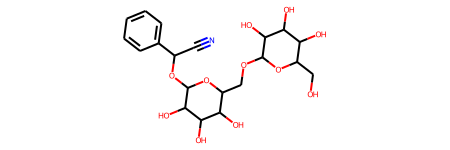

In [10]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

print(data[0]['smiles'])

sample_molecule = Chem.MolFromSmiles(data[0]["smiles"])

sample_molecule

# Modeling

In [11]:
import torch
from torch import nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, TopKPooling
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool


In [12]:
class GCN(nn.Module):
  def __init__(self, data, embedding_size):
    super(GCN, self).__init__()

    self.init_conv = GCNConv(data.num_features, embedding_size)     # called massage passing 
    self.Conv1 = GCNConv(embedding_size, embedding_size)
    self.Conv2 = GCNConv(embedding_size, embedding_size)
    self.Conv3 = GCNConv(embedding_size, embedding_size)

    self.fc = nn.Linear(embedding_size * 2, 1)

  def forward(self, inputs, edge_index, batch_index):

    X = self.init_conv(inputs, edge_index)
    X = F.tanh(X)

    X = self.Conv1(X, edge_index)
    X = F.tanh(X)
    X = self.Conv2(X, edge_index)
    X = F.tanh(X)
    X = self.Conv3(X, edge_index)
    X = F.tanh(X)

    X = torch.cat([global_max_pool(X, batch_index), global_mean_pool(X, batch_index)], dim=1)

    output = self.fc(X)

    return output, X



In [15]:
embedding_size = 128

model = GCN(data, embedding_size)

print(model)

GCN(
  (init_conv): GCNConv(9, 128)
  (Conv1): GCNConv(128, 128)
  (Conv2): GCNConv(128, 128)
  (Conv3): GCNConv(128, 128)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


# Experience

In [16]:
from torch_geometric.data import DataLoader

# train : 0.8, test : 0.2
train_loader = DataLoader(data[ : int(len(data) * 0.8)], batch_size = 128, shuffle = True)
test_loader = DataLoader(data[int(len(data) * 0.8) : ], batch_size = 128, shuffle = True)

learning_rate = 0.0001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [17]:
# train

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

EPOCH = 1000

losses = []

for epoch in range(EPOCH):

  for batch in train_loader:
    batch.to(device)

    optimizer.zero_grad()

    pred, embedding_table = model(batch.x.float(), batch.edge_index, batch.batch)

    loss = criterion(pred, batch.y)
    loss.backward()

    optimizer.step()

  losses.append(loss)

  if epoch % 100 == 0:
    print("epoch : {}, train loss : {}".format(epoch, loss))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch : 0, train loss : 12.324721336364746
epoch : 100, train loss : 1.1918060779571533
epoch : 200, train loss : 1.013495922088623
epoch : 300, train loss : 1.3116763830184937
epoch : 400, train loss : 0.5604926943778992
epoch : 500, train loss : 0.529731035232544
epoch : 600, train loss : 1.2599737644195557
epoch : 700, train loss : 0.46583080291748047
epoch : 800, train loss : 0.5737015604972839
epoch : 900, train loss : 0.4514717757701874


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


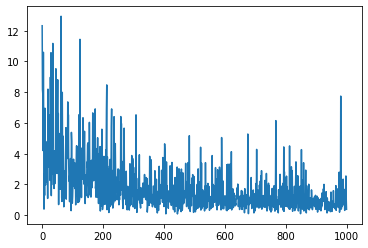

In [18]:
# visualize
import seaborn as sns

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)

plt

In [19]:
# test

test_batch = next(iter(test_loader))    # batchs to one batch
with torch.no_grad():
  test_batch.to(device)

  pred, embedding_table = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)

  print("Target : {}".format(test_batch.y.tolist()[:10]))
  print("Predict : {}".format(pred.tolist()[:10]))


Target : [[-4.743000030517578], [-2.3499999046325684], [-3.2200000286102295], [-5.03000020980835], [-8.399999618530273], [-2.3489999771118164], [-4.521999835968018], [0.15000000596046448], [-4.800000190734863], [-2.878000020980835]]
Predict : [[-4.980221748352051], [-3.460402488708496], [-3.7352352142333984], [-4.904178142547607], [-6.204025745391846], [-2.4301388263702393], [-5.338284015655518], [-0.03923952579498291], [-3.9277448654174805], [-4.342751979827881]]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
